The goal of this notebook is to reimplement the Ising problem in the original cQAOA notebook through Ben's ansatz script.

In [1]:
import sys
import cirq
import numpy as np
import networkx as nx
sys.path.append('cqaoa')
from ansatz import *
from ising import *
from training import *
import math
from itertools import product
from brute_force import *

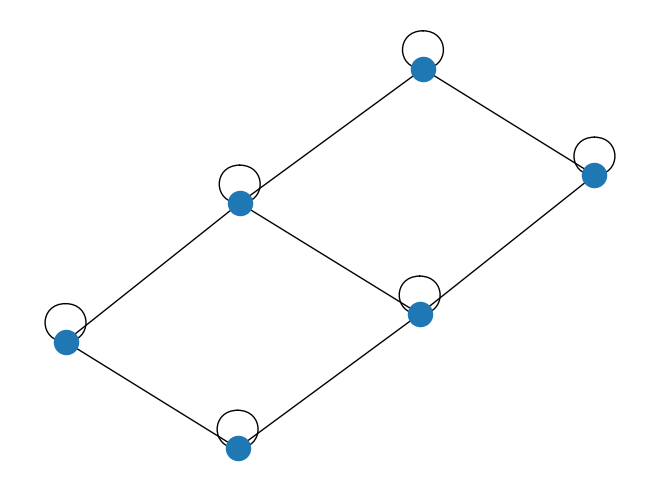

In [2]:
n_rows = 2
n_cols = 3
p=6
h = 0.5 * np.ones((n_rows, n_cols)) #Uniform local field of strength 0.5

qs = [[cirq.GridQubit(i, j) for j in range(n_cols)] for i in range(n_rows)]
qubit_graph = nx.Graph()
for i in range(n_rows):
    for j in range(n_cols):
        if j<n_cols-1:
            qubit_graph.add_edge(qs[i][j], qs[i][j+1],weight=1.01)
        if i<n_rows-1:
            qubit_graph.add_edge(qs[i][j], qs[i+1][j],weight=1.01)
for i in range(n_rows):
    for j in range(n_cols):
        qubit_graph.add_edge(qs[i][j], qs[i][j],weight=1.01)
nx.draw(qubit_graph)
ham = ising_hamiltonian(qubit_graph, weighted=True)

In [4]:
ansatz = CylicQAOAAnsatz(qubit_graph, ham, weighted=True)

no_reference_energy, gamma, beta = optimize_ansatz_random_start(ansatz, 6, 10)
print(no_reference_energy)

-6.945681235705269


In [3]:
cyclic_train(qubit_graph,ham,p=3,rounds=2, weighted = True)

Cyclic QAOA round 1 of 2.
Cyclic QAOA round 2 of 2.


CyclicResult(ansatz=<ansatz.CylicQAOAAnsatz object at 0x1465eafa0310>, energy_expectations=[-6.706188711960857, -7.070000701522224], all_sampled_energies=array([[-7.07, -7.07],
       [-7.07, -7.07],
       [-7.07, -7.07],
       ...,
       [-7.07, -7.07],
       [-7.07, -7.07],
       [-2.02, -7.07]]), lowest_sample_energy=[-7.07, -7.07], references=[[True, True, True, True, True, True], [0, 1, 0, 0, 0, 1]], gammas=[array([-0.15170391,  0.08454181,  1.59069224]), array([-3.86429276e-05,  1.73266752e+00,  2.47539487e-01])], betas=[array([0.72297269, 0.6413579 , 0.10747902]), array([0.75004546, 0.99990858, 0.50007148])])

Okay, that seems to work as expected.  Slightly better performance occurred for the cyclic variation, but this seems to have occurred at round 1, so likely the result of sampling. (?)
Let's consider seeded random local fields

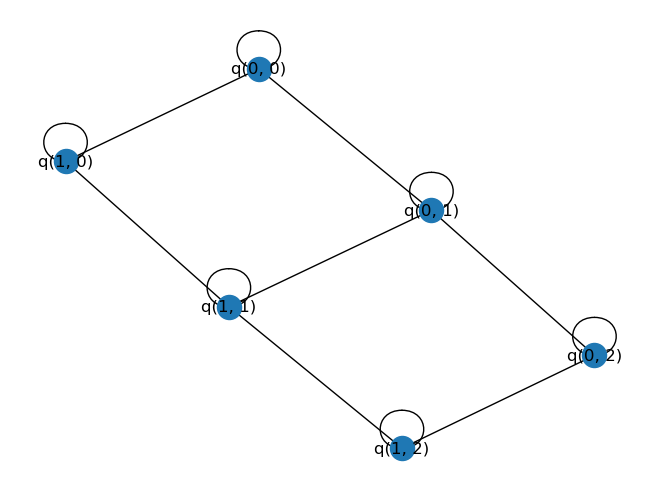

In [11]:
np.random.seed(42)
n_rows = 2
n_cols = 3
p=6
h = 0.5 * np.ones((n_rows, n_cols)) #Uniform local field of strength 0.5

qs = [[cirq.GridQubit(i, j) for j in range(n_cols)] for i in range(n_rows)]
qubit_graph = nx.Graph()
for i in range(n_rows):
    for j in range(n_cols):
        if j<n_cols-1:
            qubit_graph.add_edge(qs[i][j], qs[i][j+1],weight=1.0)
        if i<n_rows-1:
            qubit_graph.add_edge(qs[i][j], qs[i+1][j],weight=1.0)
for i in range(n_rows):
    for j in range(n_cols):
        qubit_graph.add_edge(qs[i][j], qs[i][j],weight=np.pi*np.random.rand())
nx.draw(qubit_graph, with_labels=True)
ham = ising_hamiltonian(qubit_graph, weighted=True)

In [12]:
ansatz = CylicQAOAAnsatz(qubit_graph, ham, weighted=True)

no_reference_energy, gamma, beta = optimize_ansatz_random_start(ansatz, 6, 10)
print(no_reference_energy)

-11.024352597774824


In [13]:
cyclic_train(qubit_graph,ham,p=3,rounds=2, weighted = True)

Cyclic QAOA round 1 of 2.
Cyclic QAOA round 2 of 2.


CyclicResult(ansatz=<ansatz.CylicQAOAAnsatz object at 0x1465ad6dbbb0>, energy_expectations=[-10.492167443595665, -10.748188773769947], all_sampled_energies=array([[-10.99039671, -11.34370168],
       [ -8.97069073, -11.34370168],
       [-11.34370168, -11.34370168],
       ...,
       [ -9.99054826,  -9.32399571],
       [-10.99039671, -11.34370168],
       [-10.01025423, -10.3635592 ]]), lowest_sample_energy=[-11.343701677006637, -11.343701677006637], references=[[True, True, True, True, True, True], [0, 0, 0, 0, 1, 0]], gammas=[array([2.1038797 , 2.66577193, 0.23074364]), array([4.05202671, 0.24243565, 1.70123538])], betas=[array([0.028839  , 1.01909769, 0.50973577]), array([0.97439508, 0.97291522, 0.49120111])])

In [30]:
#Classical Brute Force:
def generate_binary_strings(n):
    return [np.array(bits) for bits in product([0, 1], repeat=n)]
minE = math.inf
for string in generate_binary_strings(n_rows*n_cols):
    stringE = bitstring_energy(np.array(string), ham)
    if stringE  < minE:
        print('New min E found! - ', stringE, ' with string: ', string)
        minE = stringE

New min E found! -  -9.323995706280689  with string:  [0 0 0 0 0 0]
New min E found! -  -10.343853228103734  with string:  [0 0 0 0 0 1]
New min E found! -  -11.343701677006637  with string:  [0 0 0 0 1 0]


Classical brute force confirms that cQAOA finds the global minimum by the end of the first round.  QAOA does not find it in an equal number of layers.  Let's try 8 qubits:

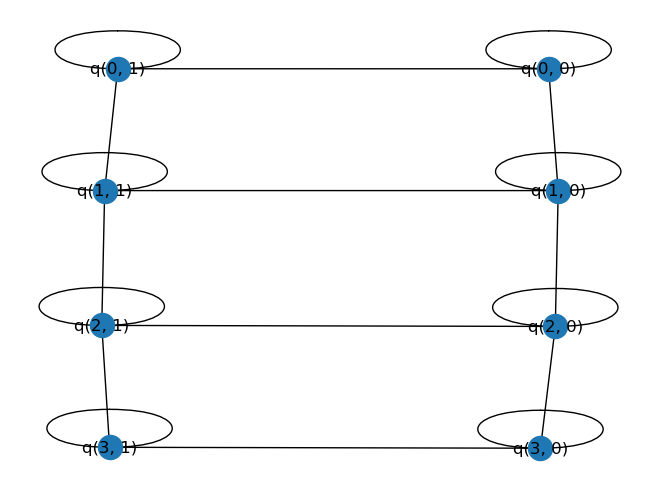

In [31]:
np.random.seed(42)
n_rows = 4
n_cols = 2
p=6
h = 0.5 * np.ones((n_rows, n_cols)) #Uniform local field of strength 0.5

qs = [[cirq.GridQubit(i, j) for j in range(n_cols)] for i in range(n_rows)]
qubit_graph = nx.Graph()
for i in range(n_rows):
    for j in range(n_cols):
        if j<n_cols-1:
            qubit_graph.add_edge(qs[i][j], qs[i][j+1],weight=1.0)
        if i<n_rows-1:
            qubit_graph.add_edge(qs[i][j], qs[i+1][j],weight=1.0)
for i in range(n_rows):
    for j in range(n_cols):
        qubit_graph.add_edge(qs[i][j], qs[i][j],weight=np.pi*np.random.rand())
nx.draw(qubit_graph, with_labels=True)
ham = ising_hamiltonian(qubit_graph, weighted=True)

In [32]:
ansatz = CylicQAOAAnsatz(qubit_graph, ham, weighted=True)

no_reference_energy, gamma, beta = optimize_ansatz_random_start(ansatz, 6, 10)
print(no_reference_energy)

-14.346253286757452


In [33]:
cyclic_train(qubit_graph,ham,p=3,rounds=2, weighted = True)

Cyclic QAOA round 1 of 2.
Cyclic QAOA round 2 of 2.


CyclicResult(ansatz=<ansatz.CylicQAOAAnsatz object at 0x1465adf2e160>, energy_expectations=[-13.905171189701964, -14.233534949774581], all_sampled_energies=array([[-15.8825508 , -14.24750089],
       [-13.86269327, -14.24750089],
       [-14.26720686, -15.8825508 ],
       ...,
       [-15.8825508 , -15.52924582],
       [-15.8825508 , -15.8825508 ],
       [-13.86269327, -13.90225677]]), lowest_sample_energy=[-15.882550795103418, -15.882550795103418], references=[[True, True, True, True, True, True, True, True], [0, 0, 0, 0, 0, 1, 1, 0]], gammas=[array([1.09142214, 0.90797308, 4.78293991]), array([ 0.0905516 ,  1.17742696, -1.03573935])], betas=[array([0.95413471, 1.49420207, 0.09632764]), array([0.51891072, 0.22263262, 0.48067072])])

In [34]:
minE = math.inf
for string in generate_binary_strings(n_rows*n_cols):
    stringE = bitstring_energy(np.array(string), ham)
    if stringE  < minE:
        print('New min E found! - ', stringE, ' with string: ', string)
        minE = stringE

New min E found! -  -12.227643371843522  with string:  [0 0 0 0 0 0 0 0]
New min E found! -  -13.862693273280373  with string:  [0 0 0 0 0 0 1 0]
New min E found! -  -14.247500893666567  with string:  [0 0 0 0 0 1 0 0]
New min E found! -  -15.882550795103418  with string:  [0 0 0 0 0 1 1 0]


Again cQAOA appears to find the global minimum while QAOA does not.  Again this appears to have happened after 1 iteration.  Let's try a Hamiltonian with random interaction strengths.

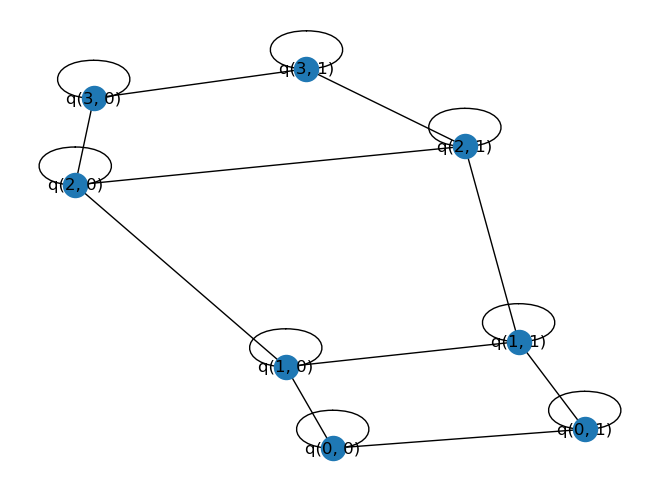

In [35]:
np.random.seed(42)
n_rows = 4
n_cols = 2
p=6
h = 0.5 * np.ones((n_rows, n_cols)) #Uniform local field of strength 0.5

qs = [[cirq.GridQubit(i, j) for j in range(n_cols)] for i in range(n_rows)]
qubit_graph = nx.Graph()
for i in range(n_rows):
    for j in range(n_cols):
        if j<n_cols-1:
            qubit_graph.add_edge(qs[i][j], qs[i][j+1],weight=np.random.rand())
        if i<n_rows-1:
            qubit_graph.add_edge(qs[i][j], qs[i+1][j],weight=np.random.rand())
for i in range(n_rows):
    for j in range(n_cols):
        qubit_graph.add_edge(qs[i][j], qs[i][j],weight=np.pi*np.random.rand())
nx.draw(qubit_graph, with_labels=True)
ham = ising_hamiltonian(qubit_graph, weighted=True)

In [36]:
ansatz = CylicQAOAAnsatz(qubit_graph, ham, weighted=True)

no_reference_energy, gamma, beta = optimize_ansatz_random_start(ansatz, 6, 10)
print(no_reference_energy)

-10.904630401456833


In [37]:
cyclic_train(qubit_graph,ham,p=3,rounds=2, weighted = True)

Cyclic QAOA round 1 of 2.
Cyclic QAOA round 2 of 2.


CyclicResult(ansatz=<ansatz.CylicQAOAAnsatz object at 0x1465e96156d0>, energy_expectations=[-10.165709532543978, -10.629926556269824], all_sampled_energies=array([[-11.34170506, -11.43202446],
       [-10.14578683, -11.49418602],
       [-11.27954349, -11.49418602],
       ...,
       [-11.27954349, -11.49418602],
       [ -8.0139113 , -11.49418602],
       [-10.14578683, -11.49418602]]), lowest_sample_energy=[-11.494186024378696, -11.494186024378696], references=[[True, True, True, True, True, True, True, True], [1, 0, 0, 1, 0, 0, 0, 0]], gammas=[array([-1.29502759,  0.10303797,  1.20586842]), array([-0.16031631,  0.24087699,  0.15369999])], betas=[array([0.90961417, 1.10436371, 0.49479775]), array([0.24392103, 0.70130942, 0.3049372 ])])

In [38]:
minE = math.inf
for string in generate_binary_strings(n_rows*n_cols):
    stringE = bitstring_energy(np.array(string), ham)
    if stringE  < minE:
        print('New min E found! - ', stringE, ' with string: ', string)
        minE = stringE

New min E found! -  -10.145786825245207  with string:  [0 0 0 0 0 0 0 0]
New min E found! -  -10.298267791236528  with string:  [0 0 0 1 0 0 0 0]
New min E found! -  -11.341705058387376  with string:  [1 0 0 0 0 0 0 0]
New min E found! -  -11.494186024378696  with string:  [1 0 0 1 0 0 0 0]


cQAOA is 3 for 3 here.  Huzzah.  Let's try 9 qubits

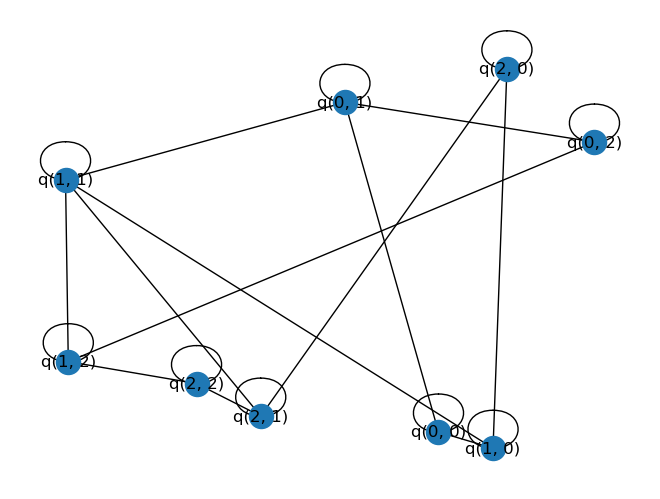

In [2]:
np.random.seed(42)
n_rows = 3
n_cols = 3
p=6
h = 0.5 * np.ones((n_rows, n_cols)) #Uniform local field of strength 0.5

qs = [[cirq.GridQubit(i, j) for j in range(n_cols)] for i in range(n_rows)]
qubit_graph = nx.Graph()
for i in range(n_rows):
    for j in range(n_cols):
        if j<n_cols-1:
            qubit_graph.add_edge(qs[i][j], qs[i][j+1],weight=np.random.uniform(-np.pi, np.pi))
        if i<n_rows-1:
            qubit_graph.add_edge(qs[i][j], qs[i+1][j],weight=np.random.uniform(-np.pi, np.pi))
for i in range(n_rows):
    for j in range(n_cols):
        qubit_graph.add_edge(qs[i][j], qs[i][j],weight=np.random.uniform(-np.pi, np.pi))
nx.draw(qubit_graph, with_labels=True)
ham = ising_hamiltonian(qubit_graph, weighted=True)

In [40]:
ansatz = CylicQAOAAnsatz(qubit_graph, ham, weighted=True)

no_reference_energy, gamma, beta = optimize_ansatz_random_start(ansatz, 6, 10)
print(no_reference_energy)

-11.769047561275467


In [41]:
cyclic_train(qubit_graph,ham,p=3,rounds=2, weighted = True)

Cyclic QAOA round 1 of 2.
Cyclic QAOA round 2 of 2.


CyclicResult(ansatz=<ansatz.CylicQAOAAnsatz object at 0x1465adf2e0a0>, energy_expectations=[-9.00802486004661, -8.52425484092055], all_sampled_energies=array([[-16.0988815 , -11.00023104],
       [ -9.19214904, -11.74924624],
       [-16.0988815 , -11.74924624],
       ...,
       [ -5.66644401, -11.74924624],
       [ -8.14592672,  -7.65523828],
       [ -7.52633651,  -9.00273284]]), lowest_sample_energy=[-17.704702818689057, -17.704702818689057], references=[[True, True, True, True, True, True, True, True, True], [0, 1, 1, 1, 1, 1, 1, 1, 0]], gammas=[array([-0.4499019 ,  1.07495006,  0.77959671]), array([ 1.58365255, -0.18101924,  1.66455646])], betas=[array([ 0.97873083, -3.04541722,  0.45770233]), array([1.00276721, 0.47802648, 0.86915427])])

In [44]:
minE = math.inf
for string in generate_binary_strings(n_rows*n_cols):
    stringE = bitstring_energy(np.array(string), ham)
    if stringE  < minE:
        print('New min E found! - ', stringE, ' with string: ', string)
        minE = stringE
        print(type(minE))
        print(type(string))

New min E found! -  5.817997388694412  with string:  [0 0 0 0 0 0 0 0 0]
<class 'float'>
<class 'numpy.ndarray'>
New min E found! -  2.9636930756264634  with string:  [0 0 0 0 0 0 0 0 1]
<class 'float'>
<class 'numpy.ndarray'>
New min E found! -  2.618906817495878  with string:  [0 0 0 0 0 0 0 1 0]
<class 'float'>
<class 'numpy.ndarray'>
New min E found! -  1.5280887931513605  with string:  [0 0 0 0 0 0 1 1 0]
<class 'float'>
<class 'numpy.ndarray'>
New min E found! -  1.4831927941835468  with string:  [0 0 0 0 0 1 0 1 0]
<class 'float'>
<class 'numpy.ndarray'>
New min E found! -  0.3923747698390283  with string:  [0 0 0 0 0 1 1 1 0]
<class 'float'>
<class 'numpy.ndarray'>
New min E found! -  -0.8907877479952009  with string:  [0 0 0 0 1 0 0 0 1]
<class 'float'>
<class 'numpy.ndarray'>
New min E found! -  -1.0557433182298617  with string:  [0 0 0 0 1 0 1 1 0]
<class 'float'>
<class 'numpy.ndarray'>
New min E found! -  -5.897481358249319  with string:  [0 0 0 1 0 0 1 1 0]
<class 'float'

In [3]:
print(brute_force(qubit_graph, ham, verbose=True))

New min E found! -  5.817997388694412  with string:  [0 0 0 0 0 0 0 0 0]
New min E found! -  2.9636930756264634  with string:  [0 0 0 0 0 0 0 0 1]
New min E found! -  2.618906817495878  with string:  [0 0 0 0 0 0 0 1 0]
New min E found! -  1.5280887931513605  with string:  [0 0 0 0 0 0 1 1 0]
New min E found! -  1.4831927941835468  with string:  [0 0 0 0 0 1 0 1 0]
New min E found! -  0.3923747698390283  with string:  [0 0 0 0 0 1 1 1 0]
New min E found! -  -0.8907877479952009  with string:  [0 0 0 0 1 0 0 0 1]
New min E found! -  -1.0557433182298617  with string:  [0 0 0 0 1 0 1 1 0]
New min E found! -  -5.897481358249319  with string:  [0 0 0 1 0 0 1 1 0]
New min E found! -  -7.033195381561651  with string:  [0 0 0 1 0 1 1 1 0]
New min E found! -  -7.0859731401682655  with string:  [0 0 0 1 1 0 0 0 1]
New min E found! -  -7.7055633516167035  with string:  [0 0 0 1 1 0 1 0 1]
New min E found! -  -12.804213820456216  with string:  [0 0 0 1 1 0 1 1 0]
New min E found! -  -14.65046031473

Here we again see that cQAOA outperforms QAOA, finding the exact global minimum after a single step.  

We recheck the last round of calculations to compare with Ben's refactor:

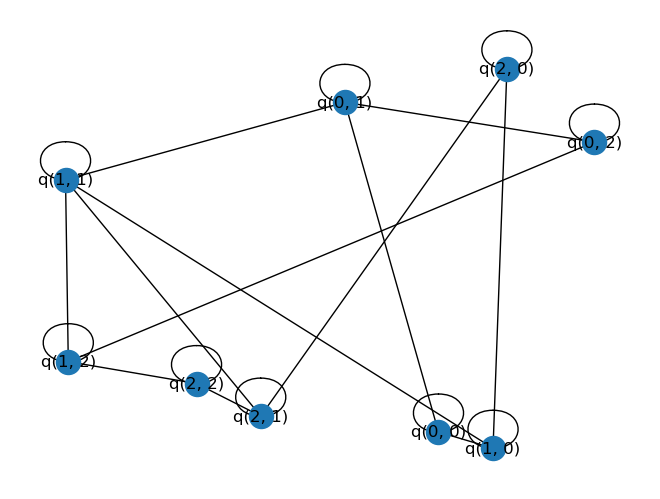

In [3]:
np.random.seed(42)
n_rows = 3
n_cols = 3
p=6
h = 0.5 * np.ones((n_rows, n_cols)) #Uniform local field of strength 0.5

qs = [[cirq.GridQubit(i, j) for j in range(n_cols)] for i in range(n_rows)]
qubit_graph = nx.Graph()
for i in range(n_rows):
    for j in range(n_cols):
        if j<n_cols-1:
            qubit_graph.add_edge(qs[i][j], qs[i][j+1],weight=np.random.uniform(-np.pi, np.pi))
        if i<n_rows-1:
            qubit_graph.add_edge(qs[i][j], qs[i+1][j],weight=np.random.uniform(-np.pi, np.pi))
for i in range(n_rows):
    for j in range(n_cols):
        qubit_graph.add_edge(qs[i][j], qs[i][j],weight=np.random.uniform(-np.pi, np.pi))
nx.draw(qubit_graph, with_labels=True)
ham = ising_hamiltonian(qubit_graph, weighted=True)

In [4]:
ansatz = CylicQAOAAnsatz(qubit_graph, ham, weighted=True)

no_reference_energy, gamma, beta = optimize_ansatz_random_start(ansatz, 6, 10)
print(no_reference_energy)

-11.769047561275467


In [5]:
cyclic_train(qubit_graph,ham,p=3,rounds=2, weighted = True)

Cyclic QAOA round 1 of 2.
Cyclic QAOA round 2 of 2.


CyclicResult(ansatz=<ansatz.CylicQAOAAnsatz object at 0x14c27063a640>, energy_expectations=[-9.00802486004661, -8.52425484092055], all_sampled_energies=array([[-16.0988815 , -11.00023104],
       [ -9.19214904, -11.74924624],
       [-16.0988815 , -11.74924624],
       ...,
       [ -5.66644401, -11.74924624],
       [ -8.14592672,  -7.65523828],
       [ -7.52633651,  -9.00273284]]), lowest_sample_energy=[-17.704702818689057, -17.704702818689057], references=[[True, True, True, True, True, True, True, True, True], [0, 1, 1, 1, 1, 1, 1, 1, 0]], gammas=[array([-0.4499019 ,  1.07495006,  0.77959671]), array([ 1.58365255, -0.18101924,  1.66455646])], betas=[array([ 0.97873083, -3.04541722,  0.45770233]), array([1.00276721, 0.47802648, 0.86915427])])

In [6]:
print(brute_force(qubit_graph, ham, verbose=True))

New min E found! -  5.817997388694412  with string:  [0 0 0 0 0 0 0 0 0]
New min E found! -  2.9636930756264634  with string:  [0 0 0 0 0 0 0 0 1]
New min E found! -  2.618906817495878  with string:  [0 0 0 0 0 0 0 1 0]
New min E found! -  1.5280887931513605  with string:  [0 0 0 0 0 0 1 1 0]
New min E found! -  1.4831927941835468  with string:  [0 0 0 0 0 1 0 1 0]
New min E found! -  0.3923747698390283  with string:  [0 0 0 0 0 1 1 1 0]
New min E found! -  -0.8907877479952009  with string:  [0 0 0 0 1 0 0 0 1]
New min E found! -  -1.0557433182298617  with string:  [0 0 0 0 1 0 1 1 0]
New min E found! -  -5.897481358249319  with string:  [0 0 0 1 0 0 1 1 0]
New min E found! -  -7.033195381561651  with string:  [0 0 0 1 0 1 1 1 0]
New min E found! -  -7.0859731401682655  with string:  [0 0 0 1 1 0 0 0 1]
New min E found! -  -7.7055633516167035  with string:  [0 0 0 1 1 0 1 0 1]
New min E found! -  -12.804213820456216  with string:  [0 0 0 1 1 0 1 1 0]
New min E found! -  -14.65046031473

Next, we need to compare to the alpha=0 schedule.

In [7]:
cyclic_train(qubit_graph, ham, p=3, rounds=2, alpha0 = 0.0, weighted = True)

Cyclic QAOA round 1 of 2.
Cyclic QAOA round 2 of 2.


CyclicResult(ansatz=<ansatz.CylicQAOAAnsatz object at 0x14c243e5fb80>, energy_expectations=[-10.930262899899658, -10.930332034150561], all_sampled_energies=array([[ -8.98498614, -16.95568762],
       [-17.70470282, -17.70470282],
       [ -1.48608314, -16.95568762],
       ...,
       [ -4.95971206, -17.70470282],
       [-12.03922865,  -3.49240683],
       [-17.70470282, -16.8478967 ]]), lowest_sample_energy=[-17.704702818689057, -17.704702818689057], references=[[True, True, True, True, True, True, True, True, True], [0, 1, 1, 1, 1, 1, 1, 1, 0]], gammas=[array([1.42666354, 1.31195971, 0.11149986]), array([1.42671309, 1.31179552, 0.11141409])], betas=[array([4.52086606, 0.99747972, 0.4561536 ]), array([2.52090713, 0.99692919, 0.45539693])])

alpha = 0 schedule also bests the higher depth QAOA.  Now what?  Let's check how many bitstrings we have sampled.